In [1]:
%load_ext autoreload
%autoreload 2

import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob
from PIL import Image
import io
from tqdm import tqdm
import re
import matplotlib.patches as mpatches
from tensorboard.backend.event_processing import event_accumulator
import pandas as pd

import os, sys
sys.path.append(os.path.join(os.getcwd(), '../sympde'))

from misc.utils import get_dict_item, read_lines, save_obj, load_obj

store_dir = '../store/analysis/'

2023-12-15 12:29:42.265199: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-15 12:29:42.265326: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-15 12:29:42.290230: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-15 12:29:42.359836: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-15 12:29:46.653951: W tensorflow/compiler/tf2

In [2]:
def get_data(filter = '', logdir = '../logs'):
    name_dirs = glob.glob(os.path.join(logdir) + '/*/*')
    data = {'_'.join(os.path.normpath(name_dir).split('/')[-2:]) : {'dir' : name_dir} for name_dir in name_dirs}

    # fitler data.keys() on regex
    pattern = re.compile(filter)
    for key in list(data.keys()):
        if not pattern.search(key):
            data.pop(key)

    return data

In [36]:
def get_results(version_dir):
    test_losses = []
    val_losses  = []
    for filename in os.listdir(version_dir):
        if 'events.out.tfevents' in filename:
            # Initialize an event accumulator.
            event_file_path = os.path.join(version_dir, filename)
            ea = event_accumulator.EventAccumulator(event_file_path,
                                                    size_guidance={event_accumulator.SCALARS: 0})

            # Load the data from the event file.
            ea.Reload()

            # Extract 'test_loss' values.
            if 'test_loss' in ea.scalars.Keys():
                test_loss_values = ea.scalars.Items('test_loss')
                for value in test_loss_values:
                    test_losses.append(value.value)
            if 'val_loss' in ea.scalars.Keys():
                val_loss_values = ea.scalars.Items('val_loss')
                for value in val_loss_values:
                    val_losses.append(value.value)

    assert len(test_losses) == 1, test_losses
    test_loss = test_losses[0]

    return np.array(test_loss), np.array(val_losses)




# def get_results(version_dir, split = 'val', test_loss: bool = False):


#     if test_loss:
#         return get_results_test_loss(version_dir, split = split)


#     val_loss = []
#     val_plot = []
#     test_loss = []
#     test_Lmse = []

#     for filename in os.listdir(version_dir):

#         if 'events.out.tfevents' in filename:

#             file_path = os.path.join(version_dir, filename)
#             raw_dataset = tf.data.TFRecordDataset(file_path)

#             try:
#                 for raw_record in raw_dataset:
#                     event = tf.compat.v1.Event.FromString(raw_record.numpy())
#                     for v in event.summary.value:
#                         if v.tag == f'val_loss':
#                             val_loss.append(v.simple_value)
                        
#                         if v.tag == f'test_Lmse':
#                             test_Lmse.append(v.simple_value)

#                         # if v.tag == f'val_plot':
#                         #     image_enc = v.image.encoded_image_string
#                         #     image = Image.open(io.BytesIO(image_enc))
#                         #     val_plot.append(image)

#                         if v.tag == f'test_loss':
#                             test_loss.append(v.simple_value)
#             except:
#                 continue

    
#     val_loss = np.array(val_loss)
#     test_loss = np.array(test_loss)
#     test_Lmse = np.array(test_Lmse)
#     return val_loss, val_plot, test_loss, test_Lmse

def get_hparams(version):
    try:
        _, net, pde, _, _, _, _= version.split('_')
    except:
        _, net, conv, pde, _, _, _, _= version.split('_')
        net = net + '_' + conv
    net = net.replace('net', '')
    return net, pde

In [37]:
def get_metrics(data):
    for version, version_dict in tqdm(data.items(), disable=False):
        # version_dict['val_loss'], version_dict['val_plot'], version_dict['test_loss'], version_dict['test_Lmse']  = get_results(version_dict['dir'])
        version_dict['test_loss'], version_dict['val_loss'] = get_results(version_dict['dir'])
        # version_dict['color'] = get_color(version)
        version_dict['net'], version_dict['pde'] = get_hparams(version)
    return data

In [38]:
n_pdes = 25
n_seeds = 3
n_nets = 5
n_runs = n_pdes * n_seeds * n_nets
print(n_runs)

375


In [39]:
data = get_data(filter = 'datav1.*version_0')
keys = list(data.keys())
print(len(keys))
assert len(keys) == n_runs, f'len(keys) = {len(keys)} != n_runs = {n_runs}'
print(keys)

remove_keys = [k for k in keys if 'Pde23' in k]
for remove_key in remove_keys:
    data.pop(remove_key)

375
['datav1_netCNN_Pde24_aug0_seed1_version_0', 'datav1_netResNet_conv_Pde7_aug0_seed1_version_0', 'datav1_netResNet_Pde23_aug0_seed1_version_0', 'datav1_netMLP_Pde1_aug0_seed3_version_0', 'datav1_netResNet_Pde4_aug0_seed2_version_0', 'datav1_netResNet_Pde12_aug0_seed3_version_0', 'datav1_netMLP_Pde5_aug0_seed3_version_0', 'datav1_netFNO1d_Pde5_aug0_seed3_version_0', 'datav1_netFNO1d_Pde2_aug0_seed3_version_0', 'datav1_netFNO1d_Pde19_aug0_seed2_version_0', 'datav1_netCNN_Pde19_aug0_seed2_version_0', 'datav1_netMLP_Pde1_aug0_seed1_version_0', 'datav1_netResNet_Pde14_aug0_seed2_version_0', 'datav1_netResNet_conv_Pde20_aug0_seed3_version_0', 'datav1_netCNN_Pde23_aug0_seed1_version_0', 'datav1_netCNN_Pde11_aug0_seed1_version_0', 'datav1_netResNet_conv_Pde18_aug0_seed1_version_0', 'datav1_netResNet_conv_Pde13_aug0_seed3_version_0', 'datav1_netResNet_Pde22_aug0_seed3_version_0', 'datav1_netFNO1d_Pde8_aug0_seed1_version_0', 'datav1_netResNet_KdV_aug0_seed3_version_0', 'datav1_netFNO1d_Pde6_a

In [40]:
data = get_metrics(data)
save_obj(data, os.path.join(store_dir, 'pdes'))

100%|██████████| 360/360 [00:35<00:00, 10.18it/s]


In [41]:
nets = np.unique(np.array([v['net'] for v in data.values()]))
pdes = np.unique(np.array([v['pde'] for v in data.values()]))

pdes_custom_order = [f'Pde{i}' for i in range(1, 25) if i != 23] + ['KdV']
nets_custom_order = ['MLP', 'CNN', 'ResNet', 'ResNet_conv', 'FNO1d']

assert set(pdes) == set(pdes_custom_order), pdes
assert set(nets) == set(nets_custom_order), nets
pdes = pdes_custom_order
nets = nets_custom_order


In [9]:
[data[f'datav1_netCNN_Pde11_aug0_seed{seed}_version_0']['test_loss'] for seed in range(1, 4)]

[array(0.02128766), array(0.01606176), array(0.48972458)]

In [10]:
[data[f'datav1_netResNet_Pde12_aug0_seed{seed}_version_0']['test_loss'] for seed in range(1, 4)]


[array(0.01140917), array(0.01873886), array(0.23953754)]

In [11]:
data.pop('datav1_netCNN_Pde11_aug0_seed3_version_0');
data.pop('datav1_netResNet_Pde12_aug0_seed3_version_0');

In [42]:
def get_df(data, value_str = 'test_loss', axis = 0):
    df = pd.DataFrame(index=pdes, columns=nets)

    for k, v in data.items():
        cell = df.loc[v['pde'], v['net']]
        value = v[value_str]
        if isinstance(cell, float):
            if pd.isnull(cell):
                cell = [value]
        else:
            cell.append(value)

        df.loc[v['pde'], v['net']] = cell

    # for row, row_data in df.iterrows():
    #     for col, cell in row_data.items():
    #         val = df.loc[row, col]
    #         try:
    #             np.array(val)
    #         except:
                
    #             print(row, col, [v.shape for v in val])

    for net in nets:
        df[net].apply(lambda x: np.mean(np.array(x), axis = axis))
        df[f'{net}_mean'] = df[net].apply(lambda x: np.mean(x, axis = axis))
        df[f'{net}_std'] = df[net].apply(lambda x: np.std(x, axis = axis))

    return df

df     = get_df(data, value_str = 'test_loss', axis = 0) 
df_val = get_df(data, value_str = 'val_loss', axis = 0)

In [43]:
# df = pd.DataFrame(index=pdes, columns=nets)

# for k, v in data.items():
#     cell = df.loc[v['pde'], v['net']]
#     value = v['test_loss']
#     if isinstance(cell, float):
#         if pd.isnull(cell):
#             cell = [value]
#     else:
#         cell.append(value)

#     df.loc[v['pde'], v['net']] = cell

# for net in nets:
#     df[f'{net}_mean'] = df[net].apply(lambda x: np.mean(x) if not None in x else None)
#     df[f'{net}_std'] = df[net].apply(lambda x: np.std(x) if not None in x else None)


# df

In [44]:
df_metrics = df.copy().drop(columns=nets)
print(df_metrics.to_markdown())

|       |   MLP_mean |     MLP_std |   CNN_mean |    CNN_std |   ResNet_mean |   ResNet_std |   ResNet_conv_mean |   ResNet_conv_std |   FNO1d_mean |   FNO1d_std |
|:------|-----------:|------------:|-----------:|-----------:|--------------:|-------------:|-------------------:|------------------:|-------------:|------------:|
| Pde1  | 0.00965092 | 0.00200209  |  0.0271538 | 0.00816946 |     0.0255707 |   0.0073054  |         0.0218778  |       0.00493804  |   0.0156913  | 0.00291149  |
| Pde2  | 0.0122482  | 0.00190739  |  0.0318844 | 0.00848136 |     0.0216153 |   0.00202999 |         0.0160161  |       0.00148763  |   0.020717   | 0.00377875  |
| Pde3  | 0.0206883  | 0.00530077  |  0.0866521 | 0.0177564  |     0.0325429 |   0.00718722 |         0.0451923  |       0.0118919   |   0.0167682  | 0.000590011 |
| Pde4  | 0.0142608  | 0.00223733  |  0.0344767 | 0.007681   |     0.0402873 |   0.00651264 |         0.0333377  |       0.00999292  |   0.0127361  | 0.002849    |
| Pde5  | 0.0096

In [45]:
for i, net in enumerate(nets):
    y    = df_metrics.iloc[i][f'{net}_mean']
    yerr = df_metrics.iloc[i][f'{net}_std']
    print(y, yerr)

0.009650923311710358 0.0020020853406904978
0.03188441010812918 0.008481360830519686
0.032542928432424865 0.007187216692603197
0.033337666963537536 0.009992915075821705
0.020423708483576775 0.002551812493923118


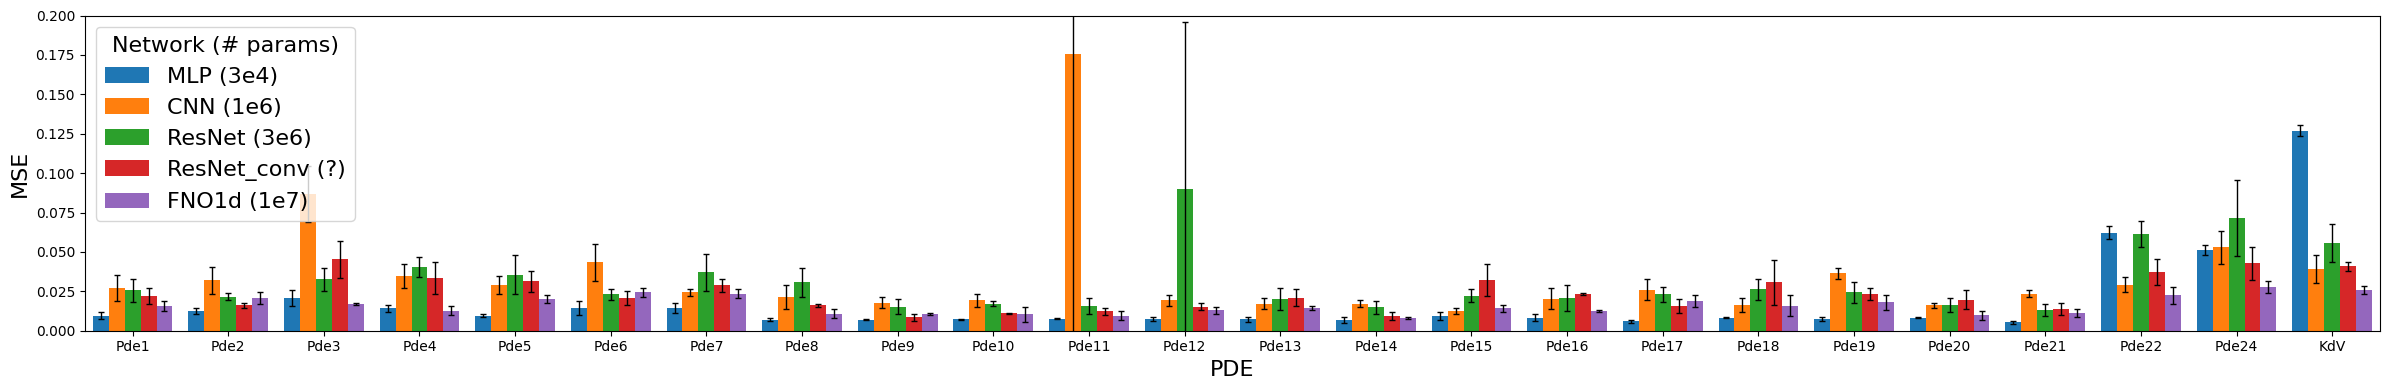

In [50]:
params_dict = {'MLP' : '3e4', 'CNN' : '1e6', 'ResNet' : '3e6', 'FNO1d' : '1e7'}

fontsize = 16
fig, axs = plt.subplots(1, 1, figsize=(len(df_metrics), 4), tight_layout=False)

ax = axs

width = 1/(len(nets)+1)
for i, (pde, vals) in enumerate(df_metrics.iterrows()):
    for j, net in enumerate(nets):
        y    = df_metrics.iloc[i][f'{net}_mean']
        yerr = df_metrics.iloc[i][f'{net}_std']
    # for j, (net, val) in enumerate(vals.items()):
        label_net = f'{net} ({params_dict[net]})' if net in params_dict else f'{net} (?)' 
        label = label_net if i == 0 else None
        ax.bar(x=i + j * width, height=y, yerr=yerr, width = width, color = f'C{j}', label = label, error_kw=dict(lw=1, capsize=2, capthick=1))
    ax.set_xticks(np.arange(len(df_metrics))+(len(vals)//2//2)*width)
    ax.set_xticklabels(list(df_metrics.index))

ax.set_ylim([0, 0.2])
ax.set_xlim([-width, len(df_metrics)-1+width*(len(nets))])
axs.legend(title = 'Network (# params)', fontsize = fontsize, loc = 2, title_fontsize = fontsize)

ax.set_xlabel('PDE', fontsize = fontsize)
ax.set_ylabel('MSE', fontsize = fontsize)

plt.show()

In [ ]:
assert False

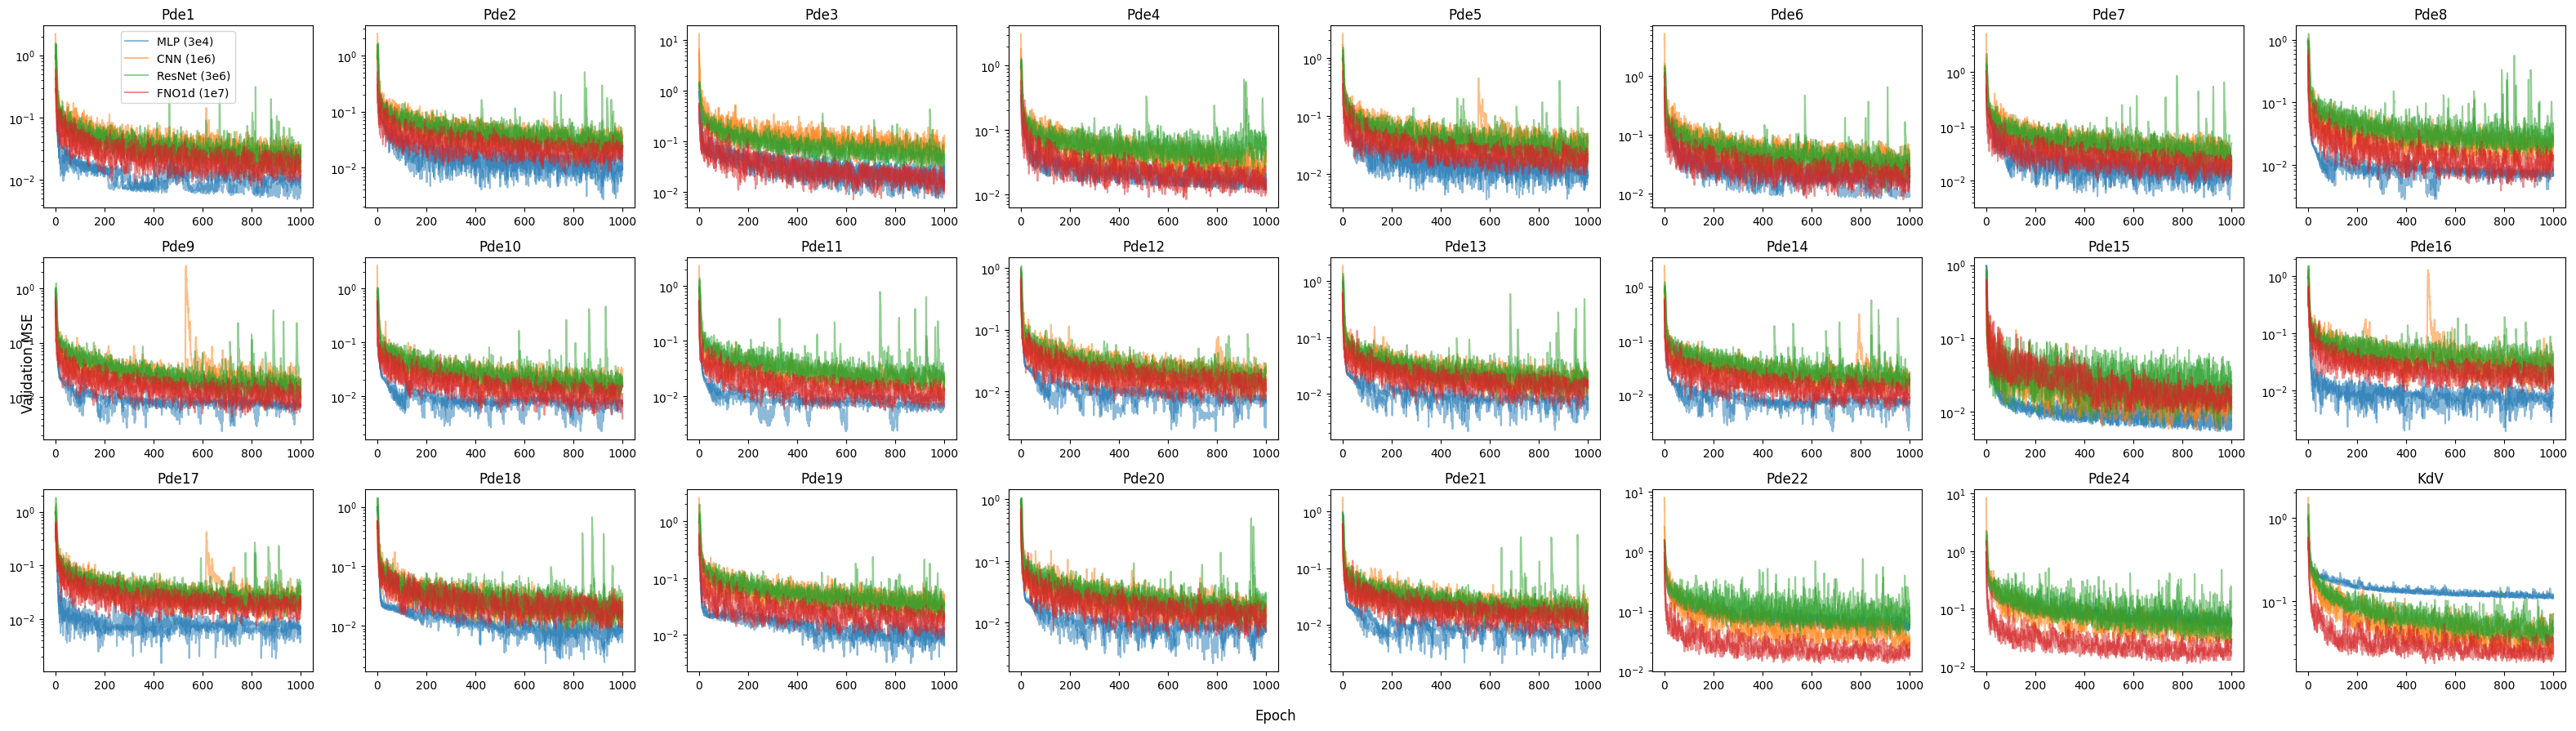

In [26]:
n_rows, n_cols = 3, 8
fig, axs = plt.subplots(n_rows, n_cols, figsize = (4*n_cols, 3*n_rows), tight_layout = False)

axs = np.array(axs).flatten()

for i, (pde, vals) in enumerate(df_val.iterrows()):
    for j, net in enumerate(nets):
        ax = axs[i]

        label_net = f'{net} ({params_dict[net]})'
        label = label_net if i == 0 else None

        # y    = df_val.iloc[i][f'{net}_mean']
        # yerr = df_val.iloc[i][f'{net}_std']
        # ax.plot(y, alpha = 0.5, label = label)

        ys = df_val.iloc[i][net]
        for k, y in enumerate(ys):
            label = label_net if i == 0 and k == 0 else None
            ax.plot(y, alpha = 0.5, color = f'C{j}', label = label)
        
        ax.set_title(pde)
        ax.set_yscale('log')

        if i == 0:
            ax.legend()

fig.supylabel('Validation MSE')
fig.supxlabel('Epoch')
plt.show()

In [ ]:
# params_dict = {'MLP' : '3e4', 'CNN' : '1e6', 'ResNet' : '3e6', 'FNO1d' : '1e7'}

# fontsize = 16
# fig, axs = plt.subplots(1, 1, figsize=(len(df_metrics), 4), tight_layout=False)

# ax = axs
# width = 0.2
# for i, (pde, vals) in enumerate(df_metrics.iterrows()):
#     for j, net in enumerate(nets):
#         y    = df_metrics.iloc[i][f'{net}_mean']
#         yerr = df_metrics.iloc[i][f'{net}_std']
#     # for j, (net, val) in enumerate(vals.items()):
#         label_net = f'{net} ({params_dict[net]})'
#         label = label_net if i == 0 else None
#         ax.bar(x=i + j * width, height=y, yerr=yerr, width = width, color = f'C{j}', label = label, error_kw=dict(lw=1, capsize=2, capthick=1))
#     ax.set_xticks(np.arange(len(df_metrics))+(len(vals)//2//2)*width)
#     ax.set_xticklabels(list(df_metrics.index))

# ax.set_ylim([0, 0.2])
# ax.set_xlim([-width, len(df_metrics)-1+width*(len(nets))])
# axs.legend(fontsize = fontsize)

# ax.set_xlabel('PDE', fontsize = fontsize)
# ax.set_ylabel('MSE', fontsize = fontsize)

# plt.show()

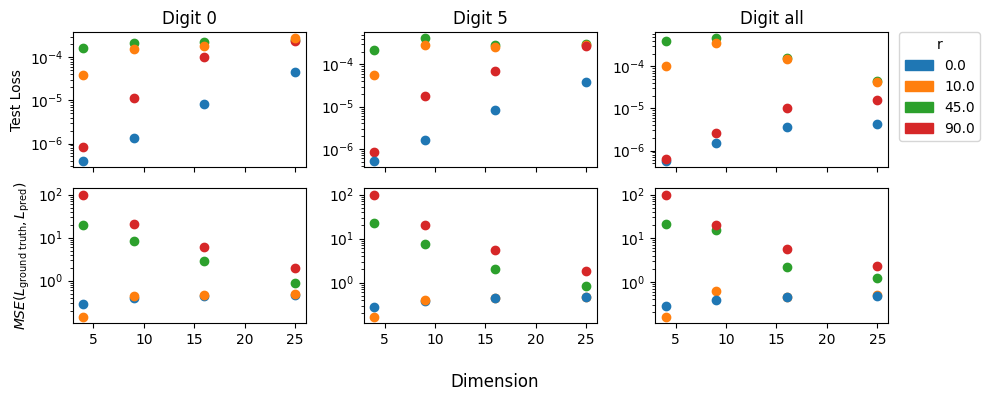

In [125]:
fig, axs = plt.subplots(2, len(digits), figsize=(10, 4), tight_layout=True, sharey=False, sharex=True)

axs_dict = {digit : ax for digit, ax in zip(digits, axs.T)}
color_dict = {r : plt.cm.tab10(i) for i, r in enumerate(rs)}
patches = [mpatches.Patch(color = color, label = r) for r, color in color_dict.items()]

for k, v in data.items():
    if len(v['test_loss']) == 0:
        print(k, 'has no test loss')
    axs_dict[str(v['digit'])][0].scatter(v['dim'], v['test_loss'], color = color_dict[v['r']], label = v['r'])
    axs_dict[str(v['digit'])][0].set_yscale('log')
    axs_dict[str(v['digit'])][1].scatter(v['dim'], v['test_Lmse'], color = color_dict[v['r']], label = v['r'])
    axs_dict[str(v['digit'])][1].set_yscale('log')
    axs_dict[str(v['digit'])][0].set_title(f'Digit {v["digit"]}')

fig.supxlabel('Dimension')
axs[0, 0].set_ylabel('Test Loss')
axs[1, 0].set_ylabel(r'$MSE(L_\text{ground truth}, L_\text{pred})$')
# fig.supylabel('Test Loss')
axs.T[-1, 0].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title = 'r')
plt.show()


Text(0, 0.5, '$MSE(L_\\text{gt}, L_\\text{pred})$')

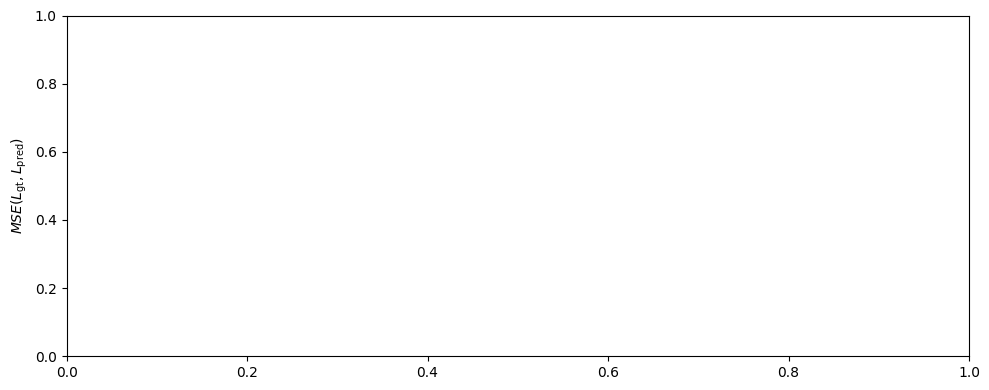

In [119]:
plt.figure(figsize=(10, 4), tight_layout=True)
plt.ylabel(r'$MSE(L_\text{ground truth}, L_\text{pred})$')

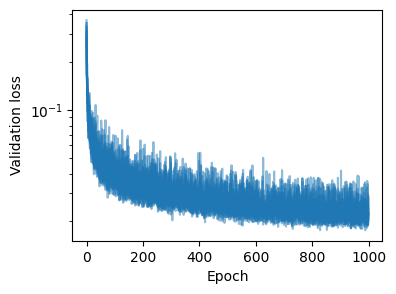

In [53]:
plt.style.use('default')


fig, axs = plt.subplots(1, 1, figsize=(4, 3))
for version, version_dict in data.items():

    if version[-1] ==  get_dict_item(data)[0][-1]:  # only one version needed for label
        if 'aug0_' in version:
            label = 'Augmentation'
        else:
            label = 'No augmentation'
    else:
        label = ''

    axs.plot(version_dict['val_loss'], label=label, color=version_dict['color'], alpha = 0.5)
axs.set_xlabel('Epoch')
axs.set_ylabel('Validation loss')
axs.set_yscale('log')
# axs.legend()
plt.show()

In [54]:
n_iterations = get_dict_item(data)[1]['val_loss'].shape[0]
val_losses = np.full((2, len(data)//2, n_iterations), np.nan)
test_losses = np.full((2, len(data)//2, 1), np.nan)
print(val_losses.shape)

(2, 5, 1000)


In [56]:
for version, version_dict in data.items():
    i_aug = 0 if 'aug0_' in version else 1
    seed = int(version[int(version.find('seed') + 4)])
    val_losses[i_aug, seed-1] = version_dict['val_loss']
    test_losses[i_aug, seed-1] = version_dict['test_loss']

assert np.isnan(val_losses).sum() == 0


In [57]:
means, stds = np.mean(test_losses, axis = 1).reshape(-1), np.std(test_losses, axis = 1).reshape(-1)
for mean, std in zip(means, stds):
    print(f"{mean:.4f} ± {std:.4f}")

0.0342 ± 0.0011
0.0324 ± 0.0026


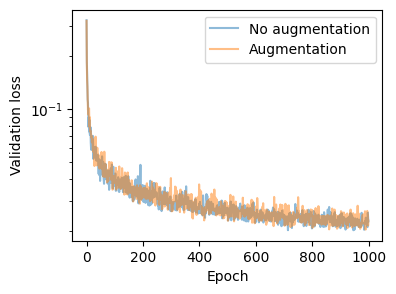

In [58]:
colors = ['tab:blue', 'tab:orange']
labels = ['No augmentation', 'Augmentation']


fig, ax = plt.subplots(1, 1, figsize=(4, 3))

for i, val_loss_aug in enumerate(val_losses):
    mean = val_loss_aug.mean(axis = 0)
    std = val_loss_aug.std(axis = 0)

    ax.plot(mean, color = colors[i], label = labels[i], alpha = 0.5)
    # ax.fill_between(np.arange(len(mean)), mean-std, mean+std, alpha = 0.5, color = colors[i])

ax.set_xlabel('Epoch')
ax.set_ylabel('Validation loss')
ax.set_yscale('log')
ax.legend()
plt.show()

### More plots

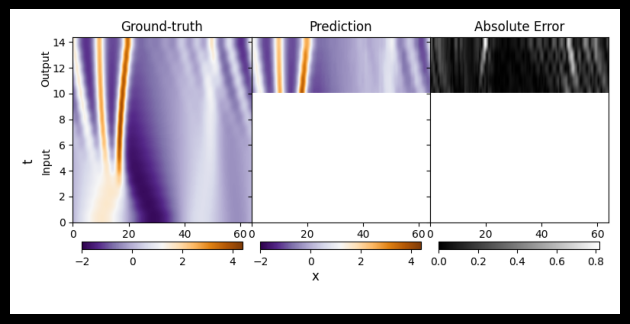

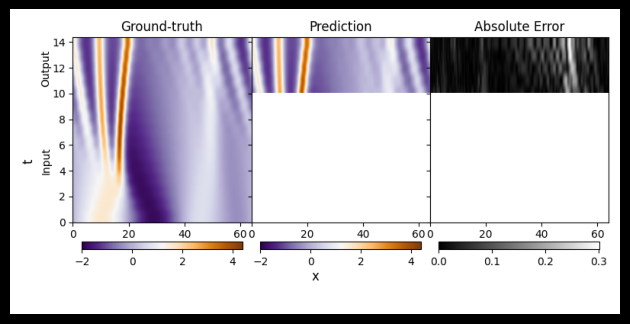

In [101]:
keys = ['FNO1d_precision_datasympde_aug0_KdV_seed4', 'FNO1d_precision_datasympde_aug1_KdV_seed4']
for key in keys:
    images = data[key]['val_plot']
    im = images[-1]
    plt.figure(tight_layout=True)
    plt.imshow(im)
    plt.axis('off')
    plt.show()